In [1]:
%matplotlib inline
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import transforms
import torchvision
import sys
from pathlib import Path

sys.path.insert(0, Path('').resolve().parent.parent.as_posix())
from utils import dl_modules
from utils.dataset import LinearRegressionDataset, FashionMNISTDataset

# 线性回归

In [2]:
batch_size = 10
num_examples = 1000
true_w = torch.tensor([2, -3.4])
true_b = 4.2
dataset = LinearRegressionDataset(true_w, true_b, num_examples)
dataloader = dataset.get_dataloader_scratch(batch_size)

## 线性模型（Scratch实现）

In [3]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b


w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


def squared_loss(y_hat, y):  # @save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


def sgd(params, lr, batch_size):  # @save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


lr = 0.03
net = linreg
loss = squared_loss
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in dataloader:
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(dataset.features, w, b), dataset.labels)
        print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")

epoch 1, loss 0.055546
epoch 2, loss 0.055546
epoch 3, loss 0.055546


# Softmax 回归

## FashionMNIST

In [4]:
root = (Path("").resolve().parent.parent / Path("data")).as_posix()
dataset = FashionMNISTDataset(root=root, resize=64)

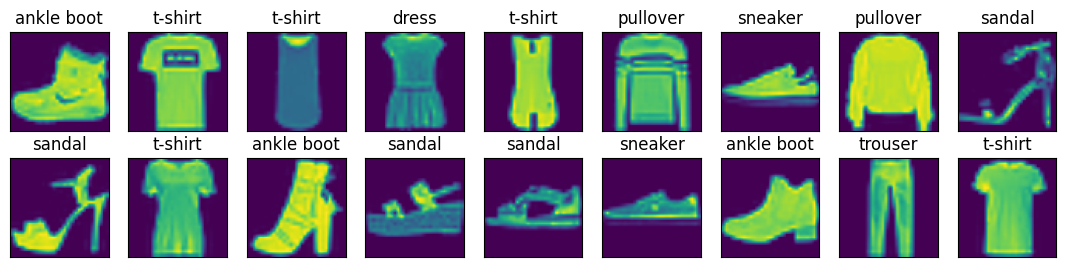

In [5]:
dataset.render()

## Softmax回归（Scratch实现）

train loss 0.525, train acc 0.826, test acc 0.820
145462.1 examples/sec on cpu


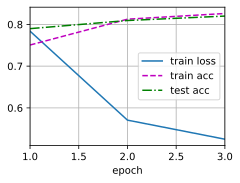

In [6]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 广播机制


def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)


def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])


def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


def updater(batch_size):
    return sgd([W, b], lr, batch_size)


lr = 0.1
dataset = FashionMNISTDataset(root=root, resize=28)
train_dataloader, test_dataloader = dataset.get_dataloader(batch_size=256)
dl_modules.train(net, train_dataloader, test_dataloader, updater=updater, loss_fn=cross_entropy, num_epochs=num_epochs)

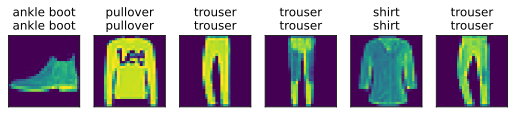

In [7]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ["t-shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
    return [text_labels[int(i)] for i in labels]


def fashion_mnist_predict(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + "\n" + pred for true, pred in zip(trues, preds)]
    dl_modules.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])


fashion_mnist_predict(net, test_dataloader)

# 多层感知机

train loss 0.383, train acc 0.865, test acc 0.834
51079.6 examples/sec on cpu


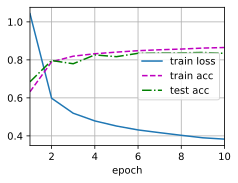

In [8]:
# scratch 实现
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]


def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)


def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X @ W1 + b1)  # 这里“@”代表矩阵乘法
    return H @ W2 + b2


loss_fn = nn.CrossEntropyLoss(reduction="none")

num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
dl_modules.train(net, train_dataloader, test_dataloader, updater, loss_fn, num_epochs)

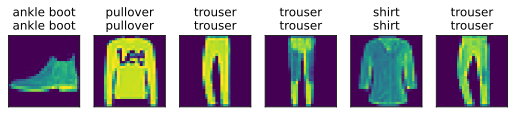

In [9]:
fashion_mnist_predict(net, test_dataloader)